In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes, cyclic_symmetry_modal_analysis, Cyclic_Symmetry_Modal_Analysis
from amfe.cyclic.cyclic import create_rotated_component
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes
from amfe.units import convert


msh_file = r'meshes\one_forth_disk_hexa_3D_v1.inp'
m = amfe.Mesh()
m.import_inp(msh_file,1000)

Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

*************************************************************

Loading Abaqus-mesh from meshes\one_forth_disk_hexa_3D_v1.inp
Can not read the given string list
WARNING! 3D case were selected
Mesh meshes\one_forth_disk_hexa_3D_v1.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


<IPython.core.display.Javascript object>


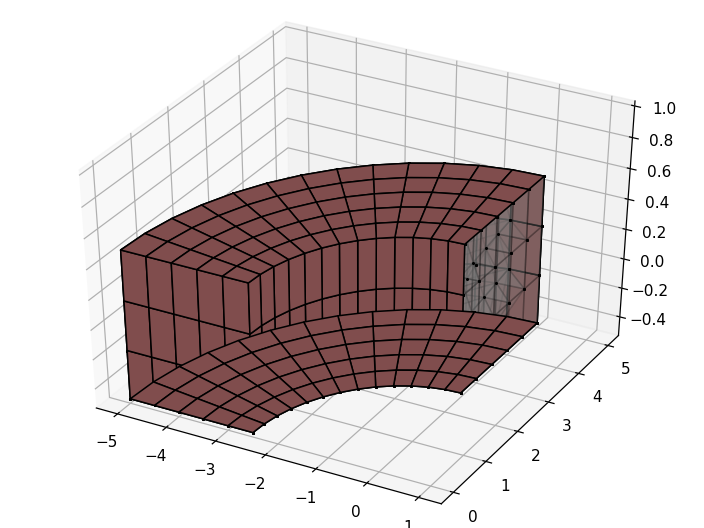

In [2]:
amfe.plotmesh(m)

In [3]:
# selection some submeshs to apply B.C.
dirsub = m.get_submesh('phys_group', 'DIRICHLET_ELSET')
cyclic_left = m.get_submesh('phys_group', 'LEFT_ELSET')
cyclic_right = m.get_submesh('phys_group', 'RIGHT_ELSET')
domain = m.set_domain('phys_group','PART_1_1_SOLID_ELSET')
domain.split_in_partitions('phys_group')


{'PART_1_1_SOLID_ELSET': <amfe.mesh.SubMesh at 0x1cf10e2f630>}

In [4]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain('PART_1_1_SOLID_ELSET',my_material)



Preallocating the stiffness matrix
Done preallocating stiffness matrix with 195 elements and 1008 dofs.
Time taken for preallocation: 0.01 seconds.


In [5]:
theta = theta = np.pi/2.0 #
n_modes = 10
cyclic_obj = Cyclic_Symmetry_Modal_Analysis(my_comp,
                               dirsub,
                               cyclic_left,
                               cyclic_right,
                               sector_angle=theta,
                               unit='rad',
                               tol_radius = 1e-3, 
                               node_diam_range = (0,10),
                               n_modes=n_modes)

comp_list = cyclic_obj.comp_ND_list
s = cyclic_obj.selector_operator


xyz direction choosen for cyclic symmetry


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


<IPython.core.display.Javascript object>


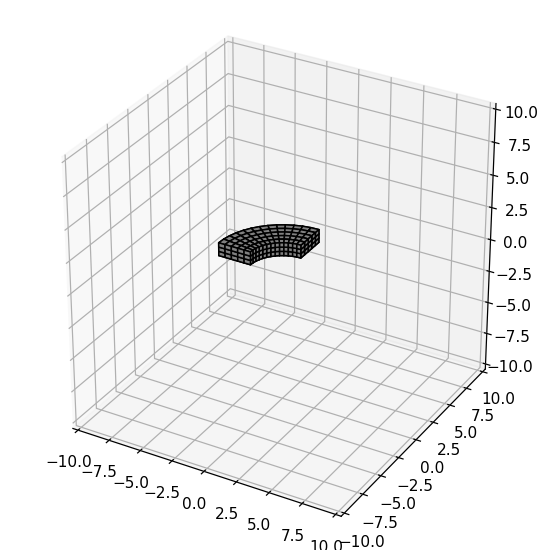

interactive(children=(FloatSlider(value=0.0, description='factor', max=1.0, min=-1.0), IntSlider(value=1, desc…

In [6]:
import mpl_toolkits.mplot3d as a3
from ipywidgets import interact


node_diam = 0
my_comp = comp_list[node_diam]
m_i = my_comp.mesh_class


displacement_list = list(np.array(my_comp.u_output).real)


fig = plt.figure(figsize=(5,5))
ax1 = a3.Axes3D(fig) 

#amfe.plot3Dmesh(m,boundaries=False)
pltmesh = amfe.Plot3DMesh(m_i, displacement_list = displacement_list, ax = ax1, alpha=1.0)
vlim=np.array([-10,10])
pltmesh.set_equal_axis_lim(vlim)

@interact(factor=(-1,1,0.1),u_id=(0,10,1))
def plot(factor=0,u_id=1):
    pltmesh.show(factor=500*factor,plot_nodes=False,displacement_id=u_id, collections=[])
    


In [7]:
n_sector = int((2.0*np.pi)/theta)
sectors_list = []
collections = []
for i in range(n_sector):
    my_comp_i = create_rotated_component(my_comp,s,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=3)    
    displacement_i = my_comp_i.u_output
    m_i = my_comp_i.mesh_class
    pltmesh_i = amfe.Plot3DMesh(m_i , scale=1, displacement_list = displacement_i, alpha=1)
    sectors_list.append(pltmesh_i) 

<IPython.core.display.Javascript object>


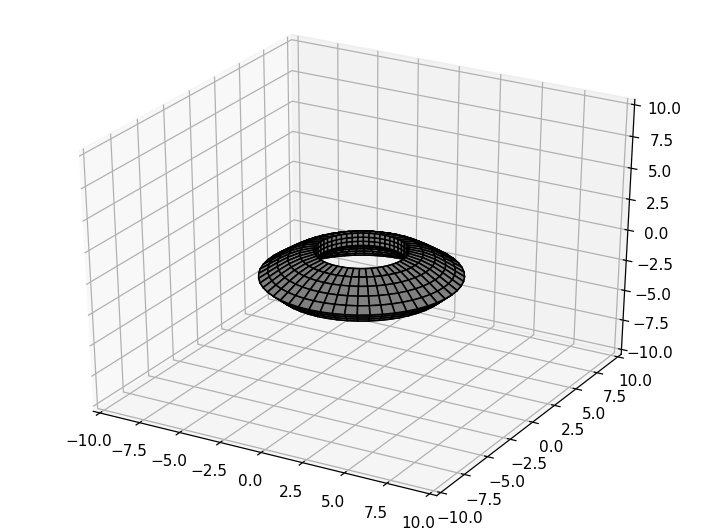

interactive(children=(FloatSlider(value=0.0, description='factor', max=1.0, min=-1.0), IntSlider(value=1, desc…

In [14]:

fig4 = plt.figure()
ax4 = a3.Axes3D(fig4) 
bc = np.array([-10,10])
ax4.set_xlim(bc)
ax4.set_ylim(bc)
ax4.set_zlim(bc)

@interact(factor=(-1,1,0.1),mode_id=(0,n_modes,1))
def plot_3d_cyclic_shape(factor=0,mode_id=1):
    n_sector = int((2.0*np.pi)/theta)
    collections = []
    for n_sector in range(n_sector):
        pltmesh_i = sectors_list[n_sector]
        pltmesh_i.show(factor=500*factor,plot_nodes=False,displacement_id=mode_id,collections=collections,ax=ax4)
    
    patch = pltmesh_i.ax.collections
